In [207]:
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import TradingEnv, StocksEnv, Actions, Positions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

In [208]:
TICKER_SYMBOL = "GOOG"
DATASET_FILE = f"data/{TICKER_SYMBOL}.csv"

In [209]:
# load data
df = pd.read_csv(DATASET_FILE)
print(df.head())

   price      volume   sma
0   7.28   976566743  4.51
1   6.95  1031889331  4.53
2   7.11   660109011  4.55
3   7.02   509767599  4.57
4   7.03   514047581  4.59


In [210]:
# setup env
def mprocess_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, "price"].to_numpy()[start:end]
    signal_features = env.df.loc[:, ["price", "volume", "sma"]].to_numpy()[start:end]
    return prices, signal_features


class MStocksEnv(StocksEnv):
    _process_data = mprocess_data


env = MStocksEnv(df=df, window_size=200, frame_bound=(200, 4000))

In [211]:
print("env information:")
print("> shape:", env.unwrapped.shape)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> max_possible_profit:", env.unwrapped.max_possible_profit())

env information:
> shape: (200, 3)
> df.shape: (4903, 3)
> prices.shape: (4000,)
> signal_features.shape: (4000, 3)
> max_possible_profit: 42997904197.02596


In [212]:
# Hyperparameters
NUM_EPISODES = 20
BATCH_SIZE = 64
GAMMA = 0.99
LEARNING_RATE = 1e-3
TARGET_UPDATE_FREQ = 2  # episodes
MEMORY_CAPACITY = 10000
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995

In [213]:
# Define the Q-Network
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        # A simple MLP; you can customize this architecture
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
        )

    def forward(self, x):
        return self.fc(x)

In [214]:
# Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [215]:
# Preprocess environment observation
def preprocess_obs(obs):
    # Assume obs is a 2D array with shape (window_size, num_features)
    # Flatten the observation to a 1D vector
    return np.array(obs).flatten()

In [216]:
obs_space_shape = env.observation_space.shape  # e.g. (window_size, num_features)
input_dim = np.prod(obs_space_shape)  # flatten the observation
output_dim = env.action_space.n  # 2 actions: Sell (0) and Buy (1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [217]:
# Main Training Loop
def train():
    policy_net = DQN(input_dim, output_dim).to(device)
    target_net = DQN(input_dim, output_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
    memory = ReplayMemory(MEMORY_CAPACITY)
    epsilon = EPS_START

    for episode in range(NUM_EPISODES):
        obs, info = env.reset(seed=episode)
        obs = preprocess_obs(obs)
        total_reward = 0
        done = False

        while not done:
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
                    q_values = policy_net(state_tensor)
                    action = q_values.argmax().item()

            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            next_obs_flat = preprocess_obs(next_obs)
            total_reward += reward

            # Save transition
            memory.push((obs, action, reward, next_obs_flat, done))
            obs = next_obs_flat

            # Perform a training step
            if len(memory) >= BATCH_SIZE:
                transitions = memory.sample(BATCH_SIZE)
                batch_obs, batch_actions, batch_rewards, batch_next_obs, batch_dones = (
                    zip(*transitions)
                )

                batch_obs = torch.FloatTensor(np.array(batch_obs)).to(device)
                batch_actions = torch.LongTensor(batch_actions).unsqueeze(1).to(device)
                batch_rewards = torch.FloatTensor(batch_rewards).unsqueeze(1).to(device)
                batch_next_obs = torch.FloatTensor(np.array(batch_next_obs)).to(device)
                batch_dones = torch.FloatTensor(batch_dones).unsqueeze(1).to(device)

                # Compute current Q values
                current_q = policy_net(batch_obs).gather(1, batch_actions)

                # Compute target Q values using the target network
                with torch.no_grad():
                    max_next_q = target_net(batch_next_obs).max(1, keepdim=True)[0]
                    target_q = batch_rewards + GAMMA * max_next_q * (1 - batch_dones)

                # Compute loss (MSE)
                loss = nn.MSELoss()(current_q, target_q)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Decay epsilon
        epsilon = max(EPS_END, epsilon * EPS_DECAY)
        print(
            f"Episode {episode+1}/{NUM_EPISODES}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}"
        )

        # Update the target network periodically
        if (episode + 1) % TARGET_UPDATE_FREQ == 0:
            target_net.load_state_dict(policy_net.state_dict())

    # Save the trained model if desired
    torch.save(policy_net.state_dict(), "dqn_trading_model.pth")
    env.close()

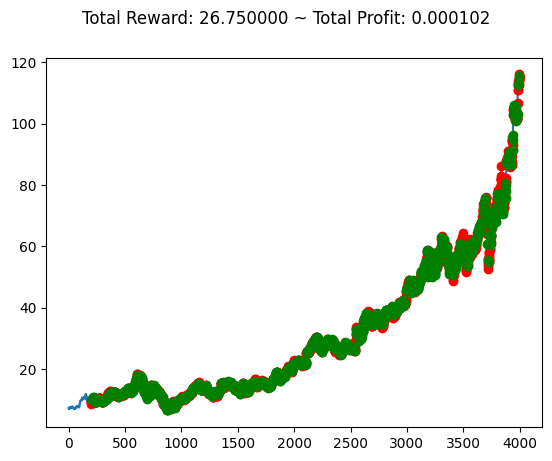

In [220]:
policy_net = DQN(input_dim, output_dim).to(device)

# Load the saved model weights
policy_net.load_state_dict(torch.load("dqn_trading_model.pth", map_location=device))
policy_net.eval()  # Set to evaluation mode

# Run the test episode
obs, info = env.reset()
obs = preprocess_obs(obs)
done = False
total_reward = 0

while not done:
    with torch.no_grad():
        state_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
        q_values = policy_net(state_tensor)
        action = q_values.argmax().item()  # Greedy action selection
    
    next_obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    total_reward += reward
    obs = preprocess_obs(next_obs)

# Optionally, render the entire episode to visualize trades
env.unwrapped.render_all()
